# Estudo de caso fraude -- Pagar.me
## Objetivo:
Entender o comportamento de fraudadores e buscar por maneiras de mitigar as ocorrências.

## Perguntas a serem respondidas:
* **Existe algum padrão no comportamento dos fraudadores?** 

* **O dataset é suficiente para tirar alguma conclusão?** 

* **Qual o poder preditivo das labels?** 

* **É possível tomar medidas preventivas?** 



In [1210]:
import os

import pandas as pd
from datetime import datetime

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("seaborn")

## Data Loading

In [1488]:
filename = '/dataset_case_boleto.csv'
path = os.getcwd() + filename
df_case_fraude = pd.read_csv(path, sep = ';', decimal = ',')

In [720]:
df_case_fraude.head()

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
0,01/03/2020,5e74d202d1498c5bdf8aafe3,cnpj,6000.0,4884.61,63500.0,2122.83,10,13,0,35,11,0,0
1,01/03/2020,5e78dafeb5ac867c7e85eb5e,cnpj,1800.0,1800.00,3600.0,0.00,0,2,0,0,11,0,0
2,01/03/2020,5e73e21359193c2f123c1076,cnpj,159.9,104.90,209.8,77.78,0,2,0,14,11,0,0
3,01/04/2020,5e7262c49d55ea5dbea59d57,cnpj,600.0,600.00,1800.0,0.00,0,3,0,18,11,0,0
4,01/04/2020,5e610d9f66945c0f82dd357f,cnpj,2941.0,1764.60,8823.0,657.63,2,5,0,65,12,0,0


## Data Cleansing 

In [1489]:
for col in [_ for _ in df_case_fraude.columns if _ not in ['mes_ref', 'company_id', 'tipo_doc', 'fraude']]:
    df_case_fraude[col] = df_case_fraude[col].astype(float)  

## Statistical analysis of numerical labels

In [1490]:
df_fraude = df_case_fraude[df_case_fraude['fraude'] == 1]
df_not_fraude = df_case_fraude[df_case_fraude['fraude'] != 1]

In [1190]:
df_fraude.describe()

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto
count,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.000000,1594.0,1594.000000
mean,4.047681e+04,1.715790e+04,7.715244e+04,1.457217e+04,0.755332,12.000627,0.654329,0.021330,1.334379,0.420326,1.0,0.002988
std,5.030391e+05,1.710111e+05,5.177692e+05,2.880853e+05,2.074958,17.958678,1.583923,0.275916,2.003884,0.493766,0.0,0.047137
min,3.000000e+00,3.000000e+00,3.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,4.622940e+03,1.680332e+03,1.293698e+04,2.270025e+02,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
50%,1.315919e+04,4.420150e+03,3.066210e+04,2.103745e+03,0.000000,5.500000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
75%,3.002622e+04,1.209766e+04,6.883418e+04,7.144502e+03,1.000000,14.000000,1.000000,0.000000,2.000000,1.000000,1.0,0.000000
max,2.000000e+07,6.736895e+06,2.021068e+07,1.148619e+07,31.000000,227.000000,22.000000,5.000000,9.000000,1.000000,1.0,1.250000


In [1191]:
df_not_fraude.describe()

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto
count,7.683000e+03,7.683000e+03,7.683000e+03,7.683000e+03,7683.000000,7683.000000,7683.000000,7683.000000,7683.000000,7683.000000,7683.0,7683.000000
mean,8.073543e+03,3.808710e+03,1.747286e+04,2.981458e+03,5.276455,10.897176,0.054926,7.285956,7.367695,0.042301,0.0,2.883959
std,2.478835e+05,1.313014e+05,2.649196e+05,1.653691e+05,25.060756,44.072942,0.587869,20.469333,4.126297,0.201289,0.0,10.045662
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,1.318500e+02,1.099050e+02,2.000000e+02,0.000000e+00,0.000000,1.000000,0.000000,0.000000,4.000000,0.000000,0.0,0.000000
50%,3.490000e+02,2.349500e+02,8.255500e+02,1.155000e+01,1.000000,2.000000,0.000000,0.000000,9.000000,0.000000,0.0,0.000000
75%,1.260000e+03,8.252800e+02,4.678735e+03,1.491800e+02,3.000000,6.000000,0.000000,6.000000,11.000000,0.000000,0.0,2.000000
max,2.147484e+07,1.123742e+07,2.247484e+07,1.447790e+07,685.000000,1103.000000,25.000000,528.000000,14.000000,1.000000,0.0,207.000000


### Existe diferenca no tipo de pessoa (Fisica e juridica) ?
##### Como se espera os fraudores tendem a serem pessoas fisicas

In [1491]:
df_fraude['tipo_doc'].value_counts()

cpf     1499
cnpj      95
Name: tipo_doc, dtype: int64

In [1492]:
df_not_fraude['tipo_doc'].value_counts()

cnpj    4456
cpf     3227
Name: tipo_doc, dtype: int64

### Maiores diferencas entre as médias (normalizado)

#### Features para observação 

* **qnt_cc_total** 

* **qtd_boleto_pago** 

* **tempo_credenciamento** 


In [1493]:
pd.DataFrame((df_fraude.describe().loc['mean'] - df_not_fraude.describe().loc['mean']) / df_fraude.describe().loc['mean']).T

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude
mean,0.800539,0.77802,0.773528,0.795401,-5.985605,0.09195,0.916057,-340.582761,-4.521441,0.899361,1.0


#### Transações Cartão de Crédito
##### Graficos qualitativos

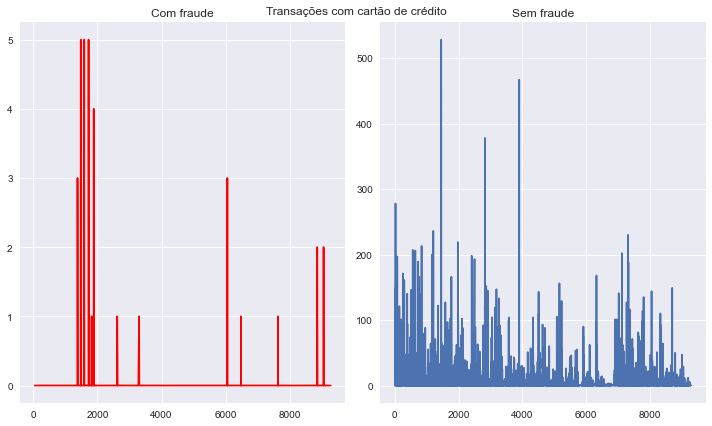

In [1199]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Transações com cartão de crédito')

ax1.plot(df_fraude['qnt_cc_total'],  color = 'red')
ax1.set_title('Com fraude');

ax2.plot(df_not_fraude['qnt_cc_total'])
ax2.set_title('Sem fraude');
plt.tight_layout()


#### Retira outliers para facilitar visualização dos gráficos 
##### Supõe distrubuição próxima de uma Gaussina


In [1293]:
avg_valor_boleto_no_fraude = df_not_fraude[df_not_fraude['avg_valor_boleto'] < (df_not_fraude['avg_valor_boleto'].std() * 1.68 + df_not_fraude['avg_valor_boleto'].mean() ) ]['avg_valor_boleto']

avg_valor_boleto_with_fraude = df_fraude[df_fraude['avg_valor_boleto'] < (df_fraude['avg_valor_boleto'].std() * 1.68 + df_fraude['avg_valor_boleto'].mean() ) ]['avg_valor_boleto']


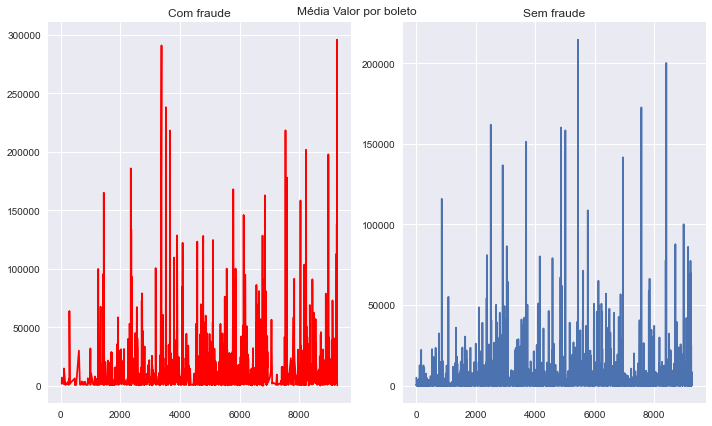

In [796]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Média Valor por boleto')

ax1.plot(avg_valor_boleto_with_fraude,  color = 'red')
ax1.set_title('Com fraude');

ax2.plot(avg_valor_boleto_no_fraude)
ax2.set_title('Sem fraude');
plt.tight_layout()
plt.show()

### Distribuição dos valores

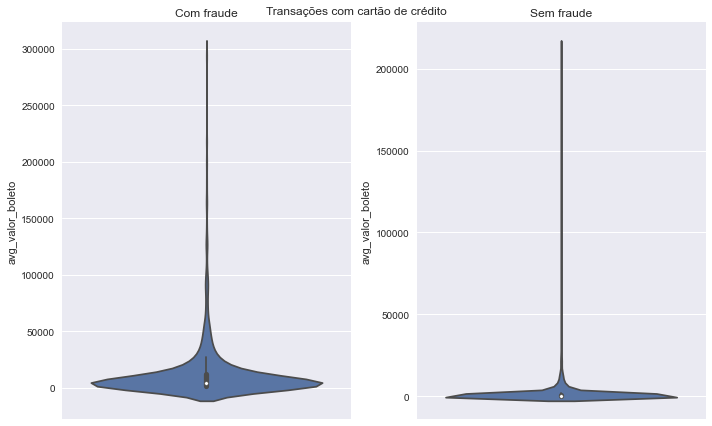

In [392]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
fig.suptitle('Transações com cartão de crédito')

sns.violinplot(avg_valor_boleto_with_fraude , ax = ax1, orient = 'v')
ax1.set_title('Com fraude');


sns.violinplot(avg_valor_boleto_no_fraude , ax = ax2, orient = 'v')
ax2.set_title('Sem fraude');

plt.tight_layout()


### Apenas Outliers

In [366]:
avg_valor_boleto_no_fraude_out = df_not_fraude[df_not_fraude['avg_valor_boleto'] > (df_not_fraude['avg_valor_boleto'].std() * 1.68 + df_not_fraude['avg_valor_boleto'].mean() ) ]['avg_valor_boleto']

avg_valor_boleto_with_fraude_out = df_fraude[df_fraude['avg_valor_boleto'] > (df_fraude['avg_valor_boleto'].std() * 1.68 + df_fraude['avg_valor_boleto'].mean() ) ]['avg_valor_boleto']


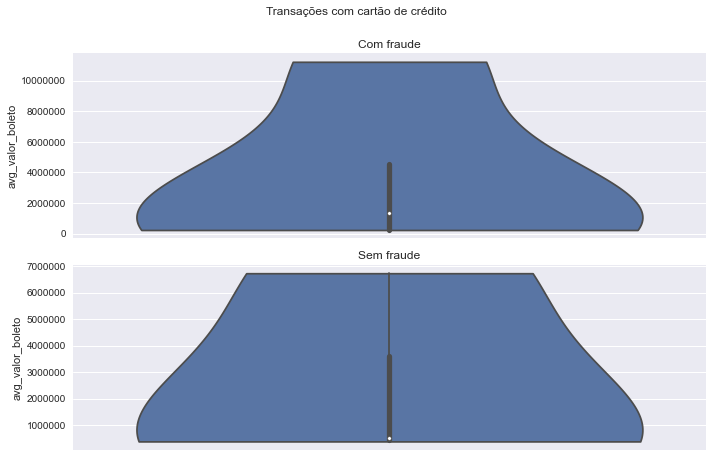

In [393]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6))
fig.suptitle('Transações com cartão de crédito',  y=1.05)

sns.violinplot(avg_valor_boleto_no_fraude_out , ax = ax1, orient = 'v', cut= 0)
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_title('Com fraude');

sns.violinplot(avg_valor_boleto_with_fraude_out , ax = ax2, orient = 'v', cut = 0, useOffset=False)
ax2.ticklabel_format(style='plain', axis='y')

ax2.set_title('Sem fraude');

plt.tight_layout()


## Algumas perguntas surgem analisando as informações acima:

* **Qual a relação entre transaçõoes no cartão de crédito e boletos emitidos? Possui carater preditivo?** 

* **Tempo de casa é uma metrica razoavel para prever possibilidade de fraude? Se sim, como não punir novos clientes?** 

* **Existe um padrão no valor dos boletos emitidos?** 

* **Qual a progressão temporal dos fraudadores? É um ato recorrente ao longo do ano ou isolado?**

In [1494]:
df_case_fraude['ratio_cc_boleto'] = df_case_fraude['qnt_cc_total']/df_case_fraude['qtd_boleto_total']

df_fraude = df_case_fraude[df_case_fraude['fraude'] == 1]
df_not_fraude = df_case_fraude[df_case_fraude['fraude'] != 1]

### Diferença normalizada indica uma distorção enorme de comportamento entre os dois grupos

In [1495]:
print('mean_fraude: {} --  mean_no_fraude: {}'.format(df_fraude['ratio_cc_boleto'].mean(),  df_not_fraude['ratio_cc_boleto'].mean()))

mean_fraude: 0.002988207629844494 --  mean_no_fraude: 2.8839585597368744


In [1496]:
(df_fraude['ratio_cc_boleto'].mean() - df_not_fraude['ratio_cc_boleto'].mean())/ df_fraude['ratio_cc_boleto'].mean()

-964.1131771880775

#### E se botassemos uma flag em todos os clientes que possuem **ratio_cc_boleto** menor que metade da média dos não fraudadores?

##### Observamos que apenas com um filtro conseguimos isolar todos os fraudadores, entretando temos ainda um número elevado de falso positivos. Para melhorar a assetividade do modelo procuramos por uma feature que prevê negativamente fraude, balanceando assim o último corte.

In [1497]:
for i in [.2, .3, .4, .6, .8, 1, 1.2, 1.4, 1.5]:
    df_filter_ratio_aux  = df_case_fraude[df_case_fraude['ratio_cc_boleto'] < i]
    print(i)
    print('Total: {} -- Fraudes: {}'.format(df_filter_ratio_aux.shape[0], df_filter_ratio_aux['fraude'].sum()))

0.2
Total: 5751 -- Fraudes: 1587
0.3
Total: 5902 -- Fraudes: 1590
0.4
Total: 6048 -- Fraudes: 1590
0.6
Total: 6312 -- Fraudes: 1591
0.8
Total: 6450 -- Fraudes: 1592
1
Total: 6525 -- Fraudes: 1592
1.2
Total: 6968 -- Fraudes: 1593
1.4
Total: 7057 -- Fraudes: 1594
1.5
Total: 7069 -- Fraudes: 1594


In [1498]:
df_filter_ratio  = df_case_fraude[df_case_fraude['ratio_cc_boleto'] < .3]

#### É natural pensar que clientes com mais tempo de casa tendem a ter uma probabilidade menor de serem fraudadores. Os dados também indicam para esse caminho. Isso se confirma?

In [1499]:
for _ in range(11):
    dataset  = df_filter_ratio[df_filter_ratio['tempo_credenciamento'] <= _]
    print(' Fraudadores: {} -- Total flag: {}  -- Anos de casa: {} -- Assertividade: {} -- % de fraudadores: {} -- Soma das %: {} \n '.format(dataset['fraude'].sum(), 
                                                                                                                                              dataset.shape[0], 
                                                                                                                                              _, 
                                                                                                                                              round(dataset['fraude'].sum()/dataset.shape[0], 3) , 
                                                                                                                                              round(dataset['fraude'].sum()/1594, 3), 
                                                                                                                                              round(dataset['fraude'].sum()/dataset.shape[0] +dataset['fraude'].sum()/1594 , 3) ))

 Fraudadores: 847 -- Total flag: 1804  -- Anos de casa: 0 -- Assertividade: 0.47 -- % de fraudadores: 0.531 -- Soma das %: 1.001 
 
 Fraudadores: 1139 -- Total flag: 2437  -- Anos de casa: 1 -- Assertividade: 0.467 -- % de fraudadores: 0.715 -- Soma das %: 1.182 
 
 Fraudadores: 1271 -- Total flag: 2724  -- Anos de casa: 2 -- Assertividade: 0.467 -- % de fraudadores: 0.797 -- Soma das %: 1.264 
 
 Fraudadores: 1320 -- Total flag: 2990  -- Anos de casa: 3 -- Assertividade: 0.441 -- % de fraudadores: 0.828 -- Soma das %: 1.27 
 
 Fraudadores: 1439 -- Total flag: 3330  -- Anos de casa: 4 -- Assertividade: 0.432 -- % de fraudadores: 0.903 -- Soma das %: 1.335 
 
 Fraudadores: 1487 -- Total flag: 3549  -- Anos de casa: 5 -- Assertividade: 0.419 -- % de fraudadores: 0.933 -- Soma das %: 1.352 
 
 Fraudadores: 1529 -- Total flag: 3761  -- Anos de casa: 6 -- Assertividade: 0.407 -- % de fraudadores: 0.959 -- Soma das %: 1.366 
 
 Fraudadores: 1573 -- Total flag: 3922  -- Anos de casa: 7 -- Ass

### Matriz de confusao do modelo acima escolhendo a maior soma

In [1500]:
dataset_filtered  = df_filter_ratio[df_filter_ratio['tempo_credenciamento'] <= 7]
print('TP: {} \t FP: {} \nFN: {}  TN: {}'.format( dataset_filtered['fraude'].sum()/df_fraude.shape[0], 
                                                 (dataset_filtered.shape[0] - dataset_filtered['fraude'].sum())/df_not_fraude.shape[0], 
                                                 (df_fraude.shape[0]-dataset_filtered['fraude'].sum())/df_fraude.shape[0], 
                                                 (df_not_fraude.shape[0]- (dataset_filtered.shape[0] - dataset_filtered['fraude'].sum()))/df_not_fraude.shape[0] ))

TP: 0.9868255959849436 	 FP: 0.30573994533385396 
FN: 0.013174404015056462  TN: 0.694260054666146


#### Sabemos que o **ratio_cc_boleto** baixo preve bem fraudadores, vamos observar no dataframe acima quais clientes apesar de possuírem meses com **ratio_cc_boleto** baixo tiveram meses com ratio grande.
#### Retirando esses clientes ficamos com:

In [1501]:
dataset_filtered  = df_filter_ratio[df_filter_ratio['tempo_credenciamento'] <= 7]
company_id_to_exclude = dataset_filtered.merge(df_case_fraude[df_case_fraude['ratio_cc_boleto'] > 0.3], on = 'company_id', how='inner')['company_id'].values
dataset_filtered  = dataset_filtered[~dataset_filtered['company_id'].isin(company_id_to_exclude)]
print('TP: {} \t FP: {} \nFN: {}  TN: {}'.format( dataset_filtered['fraude'].sum()/df_fraude.shape[0], 
                                                 (dataset_filtered.shape[0] - dataset_filtered['fraude'].sum())/df_not_fraude.shape[0], 
                                                 (df_fraude.shape[0]-dataset_filtered['fraude'].sum())/df_fraude.shape[0], 
                                                 (df_not_fraude.shape[0]- (dataset_filtered.shape[0] - dataset_filtered['fraude'].sum()))/df_not_fraude.shape[0] ))

TP: 0.9836888331242158 	 FP: 0.2931146687491865 
FN: 0.01631116687578419  TN: 0.7068853312508134


### Avançamos agora para estudo dos montantes financeiros
#### Apesar da acurácia do modelo ser razoável (com 98% de TP e 30% de falsos positivos), o montante financeiro bloqueado dos não fraudadores corresponde a 68% do montante total. 

#### Modelo atual:

In [1502]:
print('Montante fraudado: {} -- Montante de Fraude bloqueado: {} -- Montante nao fraudado: {} -- Montante nao fraudado bloqueado: {}'.format(round(df_fraude['total_valor_boleto'].sum(), 3),
                                                                                                                                             round(dataset_filtered[dataset_filtered['fraude'] == 1]['total_valor_boleto'].sum(),3), 
                                                                                                                                             round(df_not_fraude['total_valor_boleto'].sum(),3), 
                                                                                                                                             round(dataset_filtered[dataset_filtered['fraude'] != 1]['total_valor_boleto'].sum()),3))
                                                                                                                                             
                                                                                                                                              

Montante fraudado: 122980986.52 -- Montante de Fraude bloqueado: 120917295.94 -- Montante nao fraudado: 134244011.45 -- Montante nao fraudado bloqueado: 91158789


### É possivel ir mais longe? 

#### Qual a frequência com o que os clientes transacionam mês a mês?

In [1408]:
df_fraude['company_id'].value_counts()

5ecd307ba13ae25ec966033e    7
5efb636407ab9b56e30b38ed    6
5f53059e61b2d97bb54b1702    5
5f43e3c2b84925664014c1a5    5
5f7312dfac81ca5480cb8e5d    5
                           ..
601447c43c68430017c1e996    1
60240833ec8e5e0018a513d7    1
603047bfb1c91600186a562f    1
601ae3253484500012769db2    1
60009bad288da10010e16b75    1
Name: company_id, Length: 1168, dtype: int64

In [1304]:
df_case_fraude[df_case_fraude['company_id'] == '5ecd307ba13ae25ec966033e'] # Apenas fraudes

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto
762,01/08/2020,5ecd307ba13ae25ec966033e,cpf,7500.00,1608.50,17693.55,2634.81,0.0,11.0,0.0,0.0,8.0,1.0,1,0.0
1358,01/06/2020,5ecd307ba13ae25ec966033e,cpf,57660.00,3156.38,217790.34,7761.27,6.0,69.0,0.0,0.0,8.0,1.0,1,0.0
3327,01/05/2020,5ecd307ba13ae25ec966033e,cpf,10.00,10.00,10.00,0.00,1.0,1.0,0.0,0.0,8.0,1.0,1,0.0
3385,01/12/2020,5ecd307ba13ae25ec966033e,cpf,1414.84,1414.84,1414.84,0.00,0.0,1.0,0.0,0.0,8.0,1.0,1,0.0
6785,01/02/2021,5ecd307ba13ae25ec966033e,cpf,10.00,10.00,10.00,0.00,0.0,1.0,0.0,0.0,8.0,1.0,1,0.0
7984,01/07/2020,5ecd307ba13ae25ec966033e,cpf,2530.00,679.78,12236.18,500.62,1.0,18.0,0.0,0.0,8.0,1.0,1,0.0
8030,01/11/2020,5ecd307ba13ae25ec966033e,cpf,99585.84,15719.66,204355.63,29497.18,3.0,13.0,0.0,0.0,8.0,1.0,1,0.0


In [1172]:
df_not_fraude['company_id'].value_counts() 

5e1c738d7268a016d9e71108    14
5e78c7d101e84d486076b16f    13
5e7a14397250c7067fa87af3    13
5e791cc8f5c4577b9e40d75e    13
5e73911df84ce3362c22ae23    13
                            ..
601a6d0ab3e38b0011f00c24     1
6022ead6ea82e60012e73f14     1
5e700d78d95d002aa8469b5e     1
603edccf4392090012f5e67f     1
5e7e1ed7875aa946d4f0bacb     1
Name: company_id, Length: 3792, dtype: int64

In [1174]:
df_case_fraude[df_case_fraude['company_id'] == '5e1c738d7268a016d9e71108'] # Apenas nao-fraudes

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto
106,01/08/2020,5e1c738d7268a016d9e71108,cnpj,353.0,139.94,2658.97,68.14,16.0,19.0,0.0,6.0,14.0,0.0,0,0.315789
201,01/10/2020,5e1c738d7268a016d9e71108,cnpj,580.0,206.55,5370.50,130.36,20.0,26.0,0.0,10.0,14.0,0.0,0,0.384615
655,01/09/2020,5e1c738d7268a016d9e71108,cnpj,353.0,159.20,3184.00,78.96,14.0,20.0,0.0,8.0,14.0,0.0,0,0.400000
803,01/01/2020,5e1c738d7268a016d9e71108,cnpj,119.0,119.00,238.00,0.00,2.0,2.0,0.0,3.0,14.0,0.0,0,1.500000
1495,01/12/2020,5e1c738d7268a016d9e71108,cnpj,327.0,166.54,6162.33,64.63,30.0,37.0,0.0,5.0,14.0,0.0,0,0.135135
1669,01/04/2020,5e1c738d7268a016d9e71108,cnpj,218.0,131.83,2768.50,29.06,17.0,21.0,0.0,9.0,14.0,0.0,0,0.428571
2844,01/03/2020,5e1c738d7268a016d9e71108,cnpj,272.0,139.72,1537.00,68.68,8.0,11.0,0.0,4.0,14.0,0.0,0,0.363636
3421,01/03/2021,5e1c738d7268a016d9e71108,cnpj,754.0,426.50,853.00,463.15,0.0,2.0,0.0,0.0,14.0,0.0,0,0.000000
3443,01/07/2020,5e1c738d7268a016d9e71108,cnpj,353.0,144.85,3476.50,63.59,19.0,24.0,0.0,6.0,14.0,0.0,0,0.250000
4230,01/06/2020,5e1c738d7268a016d9e71108,cnpj,353.0,139.67,2793.50,55.81,16.0,20.0,0.0,8.0,14.0,0.0,0,0.400000


### Todo fraudador sempre frauda? 
#### Sim

In [1503]:
fraudadores_index = df_fraude['company_id'].values
not_fraudadores_index = df_not_fraude['company_id'].values

In [1504]:
df_case_fraude[df_case_fraude['company_id'].isin(fraudadores_index)]['fraude'].value_counts()

1    1594
Name: fraude, dtype: int64

In [1505]:
df_case_fraude[df_case_fraude['company_id'].isin(not_fraudadores_index)]['fraude'].value_counts()

0    7683
Name: fraude, dtype: int64

### Apesar de nao ser uma regra universal do negócio, vamos nos basear no comportamento mês a mês dos clientes para filtrar transações futuras baseadas em comportamento passado

In [1506]:
df_case_fraude['datetime'] = pd.to_datetime(df_case_fraude['mes_ref'])

### Identifica mês a mês clientes que possuem transações que não foram fraude

In [1507]:
dict_of_id_transactions = {}

for month_year in df_case_fraude['datetime'].unique():
    dict_of_id_transactions[month_year] = df_case_fraude[(df_case_fraude['datetime'] == month_year) & (df_case_fraude['fraude'] == 0)]['company_id'].values

### Filtra transções caso em algum mês passado o cliente tenha feito uma transação não fraudulenta
##### Obs: Não foram retiradas as primeiras transações utilizadas para definir o perfil do cliente, evitando a sobreposição de test e train datasets

In [1508]:
dataset_filtered['datetime'] = pd.to_datetime(dataset_filtered['mes_ref'])

dict_of_ids_to_disconsider = {}
for counter, key in enumerate(dict_of_id_transactions):
    dict_of_ids_to_disconsider[counter] = dataset_filtered.loc[(dataset_filtered['datetime'] > key) & (dataset_filtered['company_id'].isin(dict_of_id_transactions[key])) ]

In [1509]:
df_of_transactions_to_disconsider =  pd.concat(dict_of_ids_to_disconsider).reset_index().drop({'level_0'}, axis =1)

In [1510]:
ids_to_disconsider = set(df_of_transactions_to_disconsider['level_1'])

In [1511]:
dataset_filtered

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto,datetime
40,01/07/2020,5f20cb2cd76554110b96285f,cpf,8334.65,1468.13,39639.65,1547.70,2.0,27.0,0.0,0.0,6.0,0.0,1,0.0,2020-01-07
41,01/07/2020,5f21cc2e7c1bc041971aa1dc,cpf,12810.00,2228.29,66848.77,2991.43,3.0,30.0,0.0,0.0,5.0,1.0,0,0.0,2020-01-07
43,01/08/2020,5eda75206c50252e50d510ff,cpf,18133.80,2274.42,170581.79,3152.42,12.0,75.0,0.0,0.0,6.0,0.0,0,0.0,2020-01-08
46,01/08/2020,5f1508f3c61b83616adcb948,cpf,50106.22,6892.44,117171.53,11681.14,1.0,17.0,1.0,0.0,6.0,1.0,1,0.0,2020-01-08
81,01/06/2020,5edd69d1ec6ccd1aad6dbd14,cpf,4602.75,2356.52,23565.21,1522.47,0.0,10.0,0.0,0.0,1.0,0.0,0,0.0,2020-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9268,01/02/2021,60195d9043244b001975d012,cpf,8492.00,8492.00,8492.00,0.00,0.0,1.0,0.0,0.0,1.0,0.0,0,0.0,2021-01-02
9269,01/02/2021,601d7774028da50011fd22fa,cpf,8639.58,5160.21,10320.43,4920.57,0.0,2.0,1.0,0.0,0.0,1.0,1,0.0,2021-01-02
9270,01/02/2021,602541f58dd44a0012dd5601,cpf,5.00,5.00,5.00,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,2021-01-02
9272,01/11/2020,5fa6013aec647c00160a173b,cpf,50.00,50.00,50.00,0.00,0.0,1.0,0.0,0.0,2.0,0.0,1,0.0,2020-01-11


### Matriz de confusão para modelo com novo corte
#### Redução de 6% dos FP e redução de 23% do montante bloqueado indevidamente

In [1512]:
dataset_filtered  = df_filter_ratio[df_filter_ratio['tempo_credenciamento'] <= 7]
company_id_to_exclude = dataset_filtered.merge(df_case_fraude[df_case_fraude['ratio_cc_boleto'] > 0.3], on = 'company_id', how='inner')['company_id'].values
dataset_filtered  = dataset_filtered[~dataset_filtered['company_id'].isin(company_id_to_exclude)]

dataset_filtered  = dataset_filtered[~dataset_filtered.index.isin(ids_to_disconsider)]

print('TP: {} \t FP: {} \nFN: {}  TN: {}'.format( dataset_filtered['fraude'].sum()/df_fraude.shape[0], 
                                                 (dataset_filtered.shape[0] - dataset_filtered['fraude'].sum())/df_not_fraude.shape[0], 
                                                 (df_fraude.shape[0]-dataset_filtered['fraude'].sum())/df_fraude.shape[0], 
                                                 (df_not_fraude.shape[0]- (dataset_filtered.shape[0] - dataset_filtered['fraude'].sum()))/df_not_fraude.shape[0] ))

TP: 0.9836888331242158 	 FP: 0.23115970324092153 
FN: 0.01631116687578419  TN: 0.7688402967590785


In [1523]:
print('Montante fraudado: {} -- Montante de Fraude bloqueado: {} -- Montante nao fraudado: {} -- Montante nao fraudado bloqueado: {}'.format(round(df_fraude['total_valor_boleto'].sum(), 3),
                                                                                                                                             round(dataset_filtered[dataset_filtered['fraude'] == 1]['total_valor_boleto'].sum(),3), 
                                                                                                                                             round(df_not_fraude['total_valor_boleto'].sum(),3), 
                                                                                                                                             round(dataset_filtered[dataset_filtered['fraude'] != 1]['total_valor_boleto'].sum()),3))
                                                                                                                                             
                                                                                                                                              

Montante fraudado: 122980986.52 -- Montante de Fraude bloqueado: 120917295.94 -- Montante nao fraudado: 134244011.45 -- Montante nao fraudado bloqueado: 60683563


## Melhor resultado

In [1514]:
print('Total Fraude bloqueado %: {} -- Total Nao Fraude bloqueado indevidamente % {} -- Net: R$ {}'.format(120917295.94/122980986.52,  60683563/134244011.45, 120917295 - 60683563))

Total Fraude bloqueado %: 0.9832194338458621 -- Total Nao Fraude bloqueado indevidamente % 0.4520392555656158 -- Net: R$ 60233732


# Modelo de ML
### Como temos um dataset relativamente pequeno, a aplicação de modelos de ML muitas vezes deixa a desejar. Entretanto é interessante rodar um modelo para estudo de importância das variáveis e validação dos resultados expostos acima.
#### Vamos rodar um algotimo baseado em árvores de decisão [XGBOOST](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

# Xgboost

### Split train, test e hot encoding das variáveis categóricas
#####  A variável mês de refência não foi selecionada para evitar overfitting, uma vez que temos apenas 1 ano de dados.

In [1443]:
# A variável mes de refe
df_to_model = pd.get_dummies(df_case_fraude[['tipo_doc', 'max_valor_boleto',
       'avg_valor_boleto', 'total_valor_boleto', 'valor_boleto_stdv',
       'qtd_boleto_pago', 'qtd_boleto_total', 'qtd_boleto_estorno',
       'qnt_cc_total', 'tempo_credenciamento', 'conta_bnk_repetida',
       'ratio_cc_boleto', 'fraude']])

In [1444]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded[[i for i in df_encoded.columns if i not in ['fraude']]], df_encoded['fraude'], test_size=0.4, random_state=42)

In [1349]:
X_train.head()

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,ratio_cc_boleto,tipo_doc_cnpj,tipo_doc_cpf
8941,167348.82,7581.23,325993.05,26038.64,1,43,8,0,1,1,0.000000,0,1
8617,147.90,147.90,147.90,0.00,1,1,0,0,11,0,0.000000,1,0
7889,300.00,232.00,3480.00,72.82,13,15,0,5,10,0,0.333333,1,0
7968,101139.00,30291.29,151456.45,39731.90,0,5,0,1,5,0,0.200000,0,1
4072,40995.96,1246.20,164499.50,3789.75,5,132,0,0,1,1,0.000000,0,1


In [1445]:
import xgboost as xgb
from xgboost import XGBClassifier

ml_model_fraude = XGBClassifier()
ml_model_fraude.fit(X_train, y_train)

[11:39:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [1446]:
y_predict =  ml_model_fraude.predict(X_test)

### Matriz de confusao

In [1447]:
confusion_matrix(y_test, y_predict)

array([[2004,  157],
       [ 158,  484]], dtype=int64)

In [1448]:
print(f" Precisão fraudadores: {confusion_matrix(y_test, y_predict)[1][1]/(confusion_matrix(y_test, y_predict)[1][0] + confusion_matrix(y_test, y_predict)[1][1])},\n Precisão nao fraudadores: {confusion_matrix(y_test, y_predict)[0][0]/(confusion_matrix(y_test, y_predict)[0][0] + confusion_matrix(y_test, y_predict)[0][1])}") 

 Precisão fraudadores: 0.7538940809968847,
 Precisão nao fraudadores: 0.9273484497917631


In [1449]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2161
           1       0.76      0.75      0.75       642

    accuracy                           0.89      2803
   macro avg       0.84      0.84      0.84      2803
weighted avg       0.89      0.89      0.89      2803



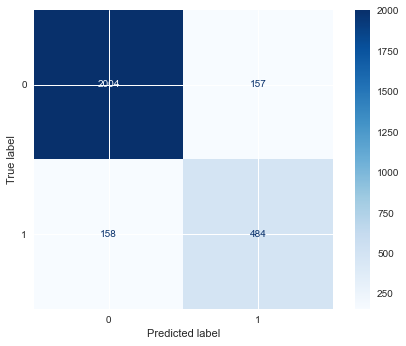

In [1450]:
disp = plot_confusion_matrix(ml_model_fraude, X_test, y_test,
                             display_labels=[0,1],
                             cmap=plt.cm.Blues)

### Vamos olhar para os montantes financeiros 

In [1452]:
X_test['y_true'] = y_test
X_test['y_predict'] = y_predict

In [1459]:
print('Total fraude: {} --  Total nao fraude: {}'.format(X_test[X_test['y_true'] == 1]['total_valor_boleto'].sum(), X_test[X_test['y_true'] != 1]['total_valor_boleto'].sum()))

Total fraude: 59995090.07 --  Total nao fraude: 65446320.47


In [1465]:
print('Total fraude bloqueado: {} --  Total nao fraude bloqueado indevidamente: {}'.format(X_test[(X_test['y_true'] == 1) &  (X_test['y_predict'] == 1) ]['total_valor_boleto'].sum(), X_test[(X_test['y_true'] == 0) &  (X_test['y_predict'] == 1) ]['total_valor_boleto'].sum()))


Total fraude bloqueado: 50507945.410000004 --  Total nao fraude bloqueado indevidamente: 36417618.95


## Estudo de importancia das variaveis
### Fazemos uma permutacao nas diferentes labels, aleatorizando seus valores, rodando e avaliando novamente o modelo para tentar entender seu poder preditivo

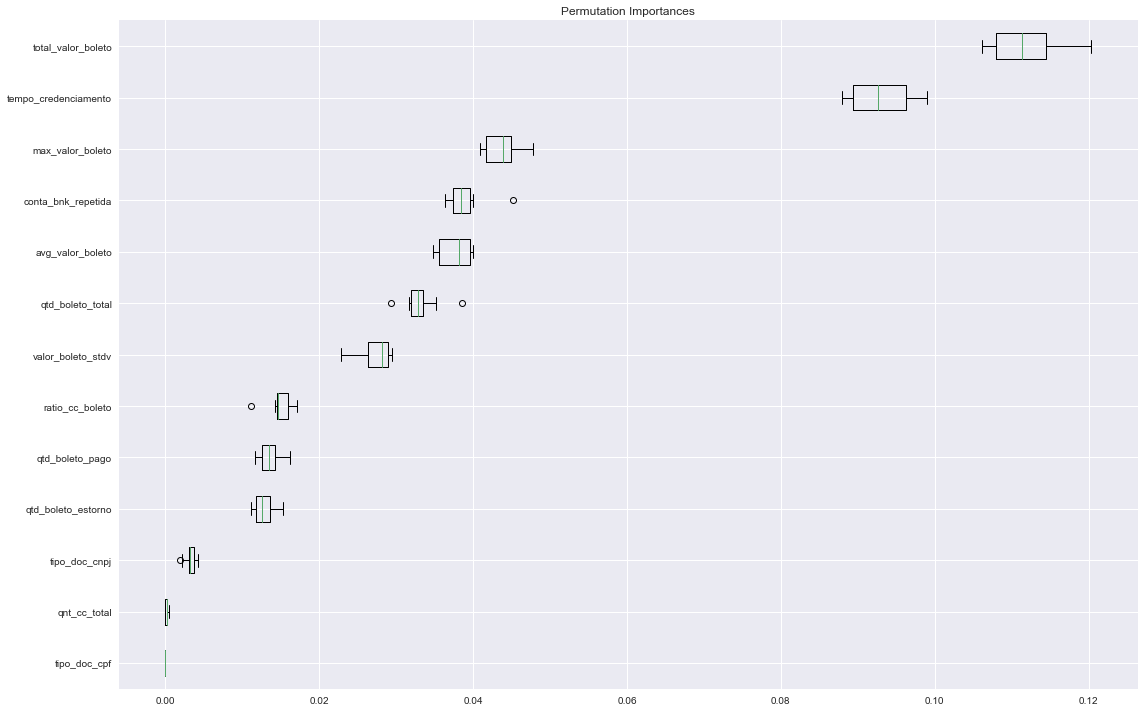

In [1410]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ml_model_fraude, X_train, y_train, n_repeats=10, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

## Aqui temos umas das biliotecas mais interessantes para analisar modelos de ML. A [SHAP](https://shap.readthedocs.io/en/latest/) faz uso de teoria dos jogos para tentar entender as relacoes entre as labels.
#### Shap values negativos indicam que a variável preve negativamente a classe (1) e as cores representam a dimensão escalar das labels.

* **No modelo abaixo vemos que tempo de credenciamento alto prevê negativamente fraude (confirmando os resultados obtidos acima);** 

* **ratio cc boleto alto prevê negativamente fraude (confirmando os resultados obtidos acima);** 

* **Conta banco repetida e qntd_boleto_estorno altos prevem positivamente (Resultado esperado, mas não foi possível achar uma corte que melhorasse os resultados do modelo)** 



In [915]:
import shap
# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(ml_model_fraude)
shap_values = explainer.shap_values(X_train)

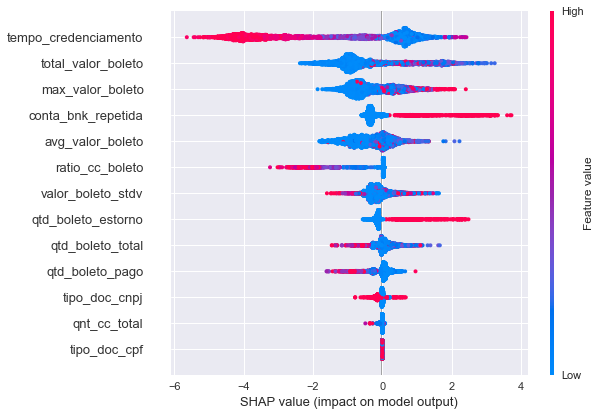

In [916]:
shap.summary_plot(shap_values, X_train)

## Discussão de ideias que podem ser interessantes mas não melhoraram o modelo
##### Observando o primeiro modelo criado, vemos que o gargalo se encontra na identificação de não fraudadores que possuem um comportamento similar aos fraudadores. Com intuito de granularizar ainda mais nosso target outras combinações de labels foram testadas.
##### Já sabemos que as labels tipo_doc, conta_bnk_repetida, total_valor_boleto, e qntd_boleto_estorno apresentam comportamento diferentes para os dois grupos, tanto de um ponto de vista social, quanto analítico. Entretanto com o dataset enviado não foi possível achar cortes que diminuissem o número de FP.  
##### Foram testados filtros de apenas cpf, total_valor_boleto acima do 2 quartil dos não fraudadores, apenas casos com desvio padrão alto e combinações entre as labels. Os resultados acabavam impactanto muito no número de fraudores identificados apesar de também diminuir o número de FP. Por isso a versão exposta do modelo foi escolhida.
##### Foi criado também um indíce de liquidez, boletos_pag/boleto_emitidos procurando pelo cenário em que esse indíce se aproxima de 1 (identifica não fraudadores), mas não foi possível achar uma combinação que melhorasse o resultado geral.

### Existe padrão temporal nos boletos emitdidos pelos fraudadores ?
#### Vemos que temos um pico de fraude nos primeiros meses do ano com uma diminuição significativa nos meses seguintes, e um possível crescimento no início do próximo ano. Possíveis motivos são as festas de final de ano, onde pessoas tendem a gastar mais dinheiro somado ao recebimento do 13 salário e bônus, criando um ambiente propício à fraude.
#### Para concluirmos de maneira categorica se esse comportamento realmente se repete, necessitariamos de pelo menos mais 2 anos de dados transacionais.

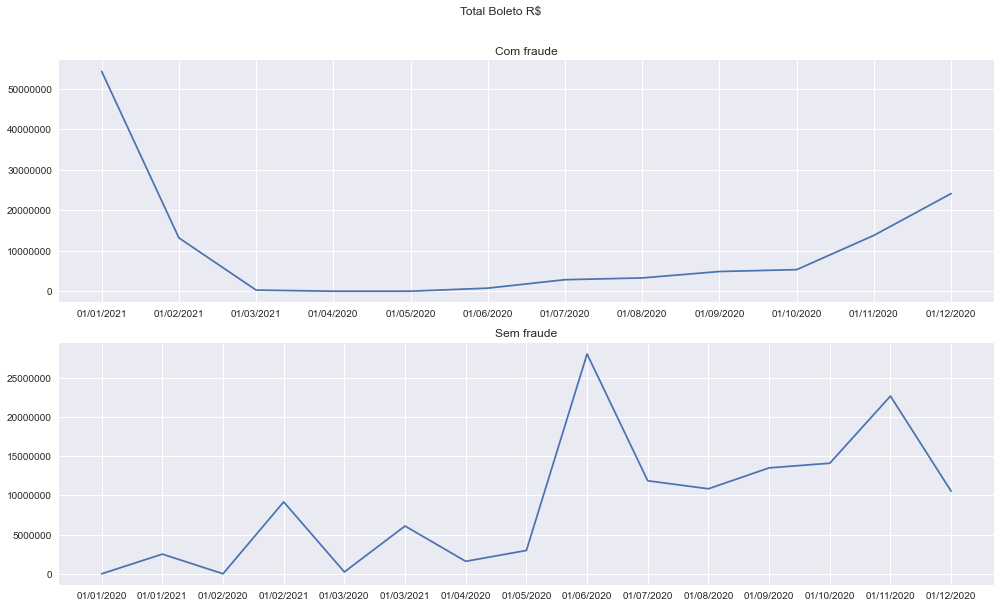

In [1540]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(14,8))
fig.suptitle('Total Boleto R$',  y=1.05)

ax1.plot(df_fraude.groupby('mes_ref').sum()['total_valor_boleto'])
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_title('Com fraude');

plt.plot(df_not_fraude.groupby('mes_ref').sum()['total_valor_boleto'])
ax2.ticklabel_format(style='plain', axis='y')

ax2.set_title('Sem fraude');

plt.tight_layout()

## Porque apesar da % de FP ser relativamente baixa (23%) o montante financeiro bloqueado indevidamente foi significativamente maior ?
#### Olhando para o dataset final do modelo, vemos que temos um total de 1176 transações que não foram fraude correspondendo a um valor de 60MM, como esse valores estão distribuidos?

In [1534]:
print(f" Total: {dataset_filtered[dataset_filtered['fraude'] == 0].shape[0]}, R$ :{dataset_filtered[dataset_filtered['fraude'] == 0]['total_valor_boleto'].sum()}")

 Total: 1776, R$ :60683562.77


### Vemos aqui que 100 transações (5.6% do total) correspondem a 35MM (58% do total)
#### Além disso esses clientes apresentam comportamento similar aos fraudadores. Baixo ratio de boleto_emitos/boletos_pagos, conta_bnk_repetida, pouco tempo de casa, e baixo ratio qnt_cc_total. Por isso novos cortes acabavam afetando a precisão de identificar fraudadores e não impactavam significativamente no montante dos FP.

In [1537]:
dataset_filtered[dataset_filtered['fraude'] != 1].sort_values(by ='total_valor_boleto' ).tail(100)['total_valor_boleto'].sum()

35215833.519999996

In [1536]:
dataset_filtered[dataset_filtered['fraude'] != 1].sort_values(by ='total_valor_boleto' ).tail(100)['total_valor_boleto']

,mes_ref,company_id,tipo_doc,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto
1752,01/06/2020,5eda3800b8a0f944a74a228f,cpf,9367.38,1807.41,162667.45,1806.56,7.0,90.0,0.0,0.0,1.0,1.0,0,0.0
4072,01/11/2020,5fbc451a9ab2b9001641ca01,cpf,40995.96,1246.20,164499.50,3789.75,5.0,132.0,0.0,0.0,1.0,1.0,0,0.0
1801,01/11/2020,5fa9465a403a3c00165e41cd,cpf,18150.00,7208.20,165788.80,5554.97,1.0,23.0,0.0,0.0,1.0,1.0,0,0.0
1292,01/10/2020,5f7e227a4940bb3214774e80,cpf,16969.20,2972.80,166477.14,3754.22,5.0,56.0,0.0,0.0,2.0,0.0,0,0.0
8918,01/11/2020,5f7319336305a02f50d893e2,cpf,12250.00,750.74,166664.73,1262.71,24.0,222.0,0.0,0.0,3.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2881,01/11/2020,5efc841b428caf2e22d2f11f,cnpj,152236.82,16353.18,735893.14,29744.91,5.0,45.0,3.0,0.0,6.0,1.0,0,0.0
885,01/10/2020,5f885119bc782339339f3c08,cpf,214935.94,15310.92,750235.24,43376.05,0.0,49.0,1.0,0.0,2.0,1.0,0,0.0
1335,01/11/2020,5faebcb6a15514001737592e,cpf,286715.43,35896.20,1005093.80,68549.82,2.0,28.0,0.0,0.0,1.0,1.0,0,0.0
2525,01/07/2020,5f18a9f7f9a6145d119e2f2d,cpf,1123461.46,40648.49,1260103.41,201185.77,2.0,31.0,0.0,0.0,5.0,0.0,0,0.0


In [1539]:
dataset_filtered[dataset_filtered['fraude'] != 1].sort_values(by ='total_valor_boleto' ).tail(100).describe()

,max_valor_boleto,avg_valor_boleto,total_valor_boleto,valor_boleto_stdv,qtd_boleto_pago,qtd_boleto_total,qtd_boleto_estorno,qnt_cc_total,tempo_credenciamento,conta_bnk_repetida,fraude,ratio_cc_boleto
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.00,100.0,100.000
mean,1.316562e+05,4.241786e+04,3.521583e+05,21177.221700,4.590000,60.210000,0.940000,0.01,2.890000,0.45,0.0,0.002
std,2.608937e+05,2.381675e+05,2.772655e+05,27991.769427,5.733289,53.654204,3.231224,0.10,2.029554,0.50,0.0,0.020
min,9.367380e+03,7.507400e+02,1.626675e+05,0.000000,0.000000,1.000000,0.000000,0.00,0.000000,0.00,0.0,0.000
25%,3.545882e+04,3.161695e+03,2.053250e+05,5189.010000,1.000000,23.750000,0.000000,0.00,1.000000,0.00,0.0,0.000
50%,6.700440e+04,6.449935e+03,2.671751e+05,10986.700000,3.000000,40.000000,0.000000,0.00,3.000000,0.00,0.0,0.000
75%,1.585513e+05,1.557149e+04,3.928568e+05,23792.915000,5.250000,86.000000,0.000000,0.00,5.000000,1.00,0.0,0.000
max,2.362717e+06,2.362717e+06,2.362717e+06,201185.770000,27.000000,245.000000,25.000000,1.00,7.000000,1.00,0.0,0.200


# Conclusões Finais 

## Padrões de Comportamento
* **O mais expressivo é a proporção de boletos emitidos pelo número de trasações com cartão de crédito (baixa). Naturalmente os fraudadores não transacionam como um cliente tradicional;** 

* **Proporção de boletos emitidos por boletos pagos. Como é de se esperar a grande maioria dos boletos emitidos pelo fraudadores não serão pagos, criando outra métrica com poder preditivo;** 

* **Valor mais elevado por boleto que os não fraudadores, tentando garantir pelo menos uma operação bem sucedida. Maior desvio padrão, os valores dos boletos muitas vezes não são coesos;** 

* **Pouco tempo de casa relativo os demais clientes. Fraudadores tendem a fraudar pouco depois de entrarem.** 

* **Aparente sazionalidade nas tentativas de fraude.** 


## Como identifica-los de maneira preventiva?

* **Observando a proporção de boletos mês a mês, transações nos cartões de créditos e boletos pagos. Observar o comportamento histórico desse cliente. Flagar os que não passarem pelos cortes das variáveis;** 

* **Nos que tiverem flag, estudar os montantes que estão sendo emitidos e se corresponde a dimensão histórica do negócio ;** 

## Como mitigar o problema?

* **É possível criar uma taxa dinâmica para emissão de boletos baseada nas features citadas acima, caso as proporções estajam longe do benchmark esses clientes teriam um custo maior para emitir boletos;**

* **Nos que tiverem flag, estudar os montantes que estão sendo emitidos (valores muito altos, desvio padrão anormal) e se corresponde a dimensão histórica do negócio ;** 

* **Limitar o valor e quantidade de boletos que podem ser emitidos, a partir de outras variáveis, i.e, tempo de casa, número mínimo de transações;** 

## Quais outros riscos o mercado de adquirência está exposto?

* **Seguindo a linha do case, uma outra possibilidade de fraude é a emissão de boletos para uma mesma conta, aumentando assim a liquidez do cliente, volume transacionado e confiabilidade, métricas que impactam diretamente nas decisões para antecipável de recebível (principal fonte de renda do Pagar.me). Esse valores altos podem levar a um aumento do valor antecipado, mais dias de antecipação e menores taxas, afetando diretamente na receita da empresa;**

* **No mercado físico de adquirência, temos o caso clássico de substituição da máquinha redirecionando os valores de venda, que pode ser evitado checando a conta cadastrada no POS. Do lado do credenciador pode ser feito um estudo dos montantes transacionados, horário e tipo do negócio;**

* **Outra prática comum é o cancelamento de uma compra com alto valor junto a um funcionário. Para evitar isso é necessário a verificação diária de todas as transações canceladas no estabelecimento;**


